In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('../src/data.csv', delimiter=';')

In [4]:
df_genre = df.assign(genres=df['genres'].str.split(',')).explode('genres')

In [5]:
df_directors = df.assign(directors=df['directors'].str.split(',')).explode('directors')

Movies per year

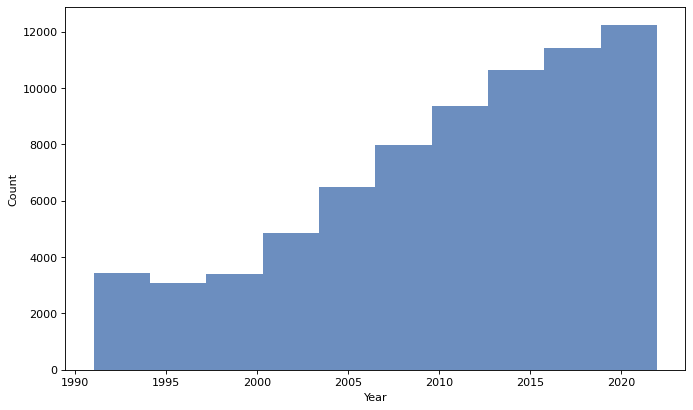

In [7]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(df['startYear'], color='#6C8EBF')  
plt.ylabel('Count')
plt.xlabel('Year')

plt.savefig('../docs/graphics/movies_per_year.png')


Movies per genre

Text(0.5, 0, 'Genre')

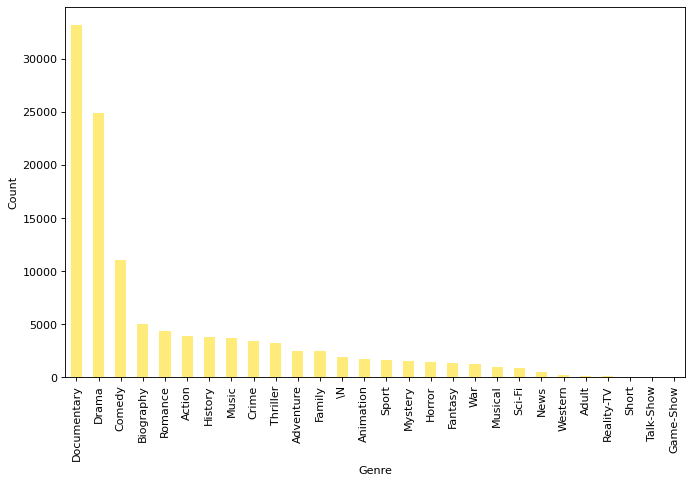

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.xticks(rotation=90)
df_genre['genres'].value_counts().plot.bar(color='#FFEB79')

plt.ylabel('Count')
plt.xlabel('Genre')


plt.savefig('./pictures/number_movies_per_year.png')


Text(0.5, 0, 'Adult movies')

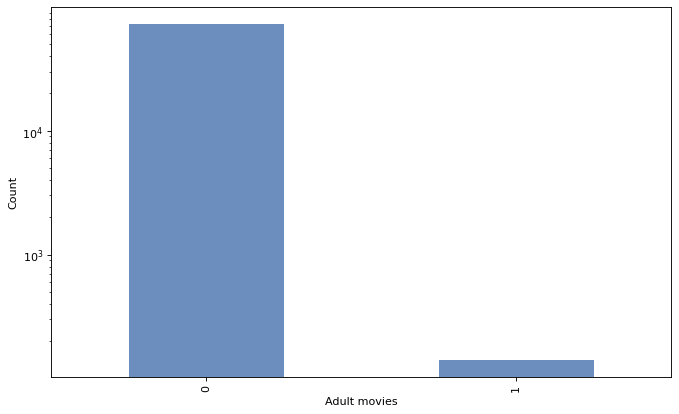

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
df['isAdult'].value_counts().plot.bar(color='#6C8EBF')

plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('Adult movies')

#movies_year.plot.bar()
#fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
#fig.savefig('./pictures/number_movies_per_year.png')
#plt.clf()

In [ ]:
df['isAdult'].value_counts()

0    72757
1      141
Name: isAdult, dtype: int64

Text(0.5, 0, 'Average Rating')

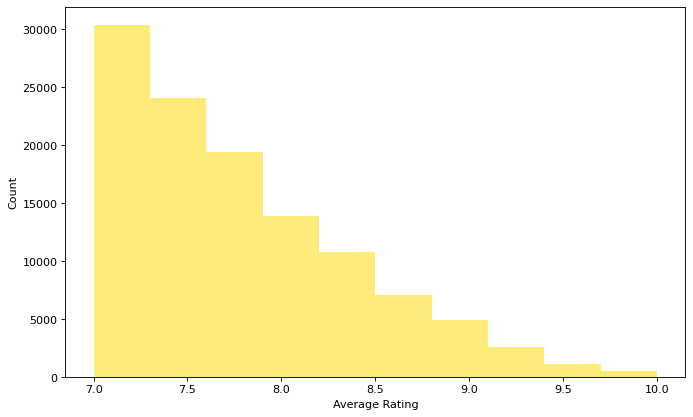

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(df_genre['averageRating'], color='#FFEB79')  
plt.ylabel('Count')
plt.xlabel('Average Rating')

#fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
#fig.savefig('./pictures/number_movies_per_year.png')
#plt.clf()

<AxesSubplot: title={'center': 'averageRating'}, xlabel='genres'>

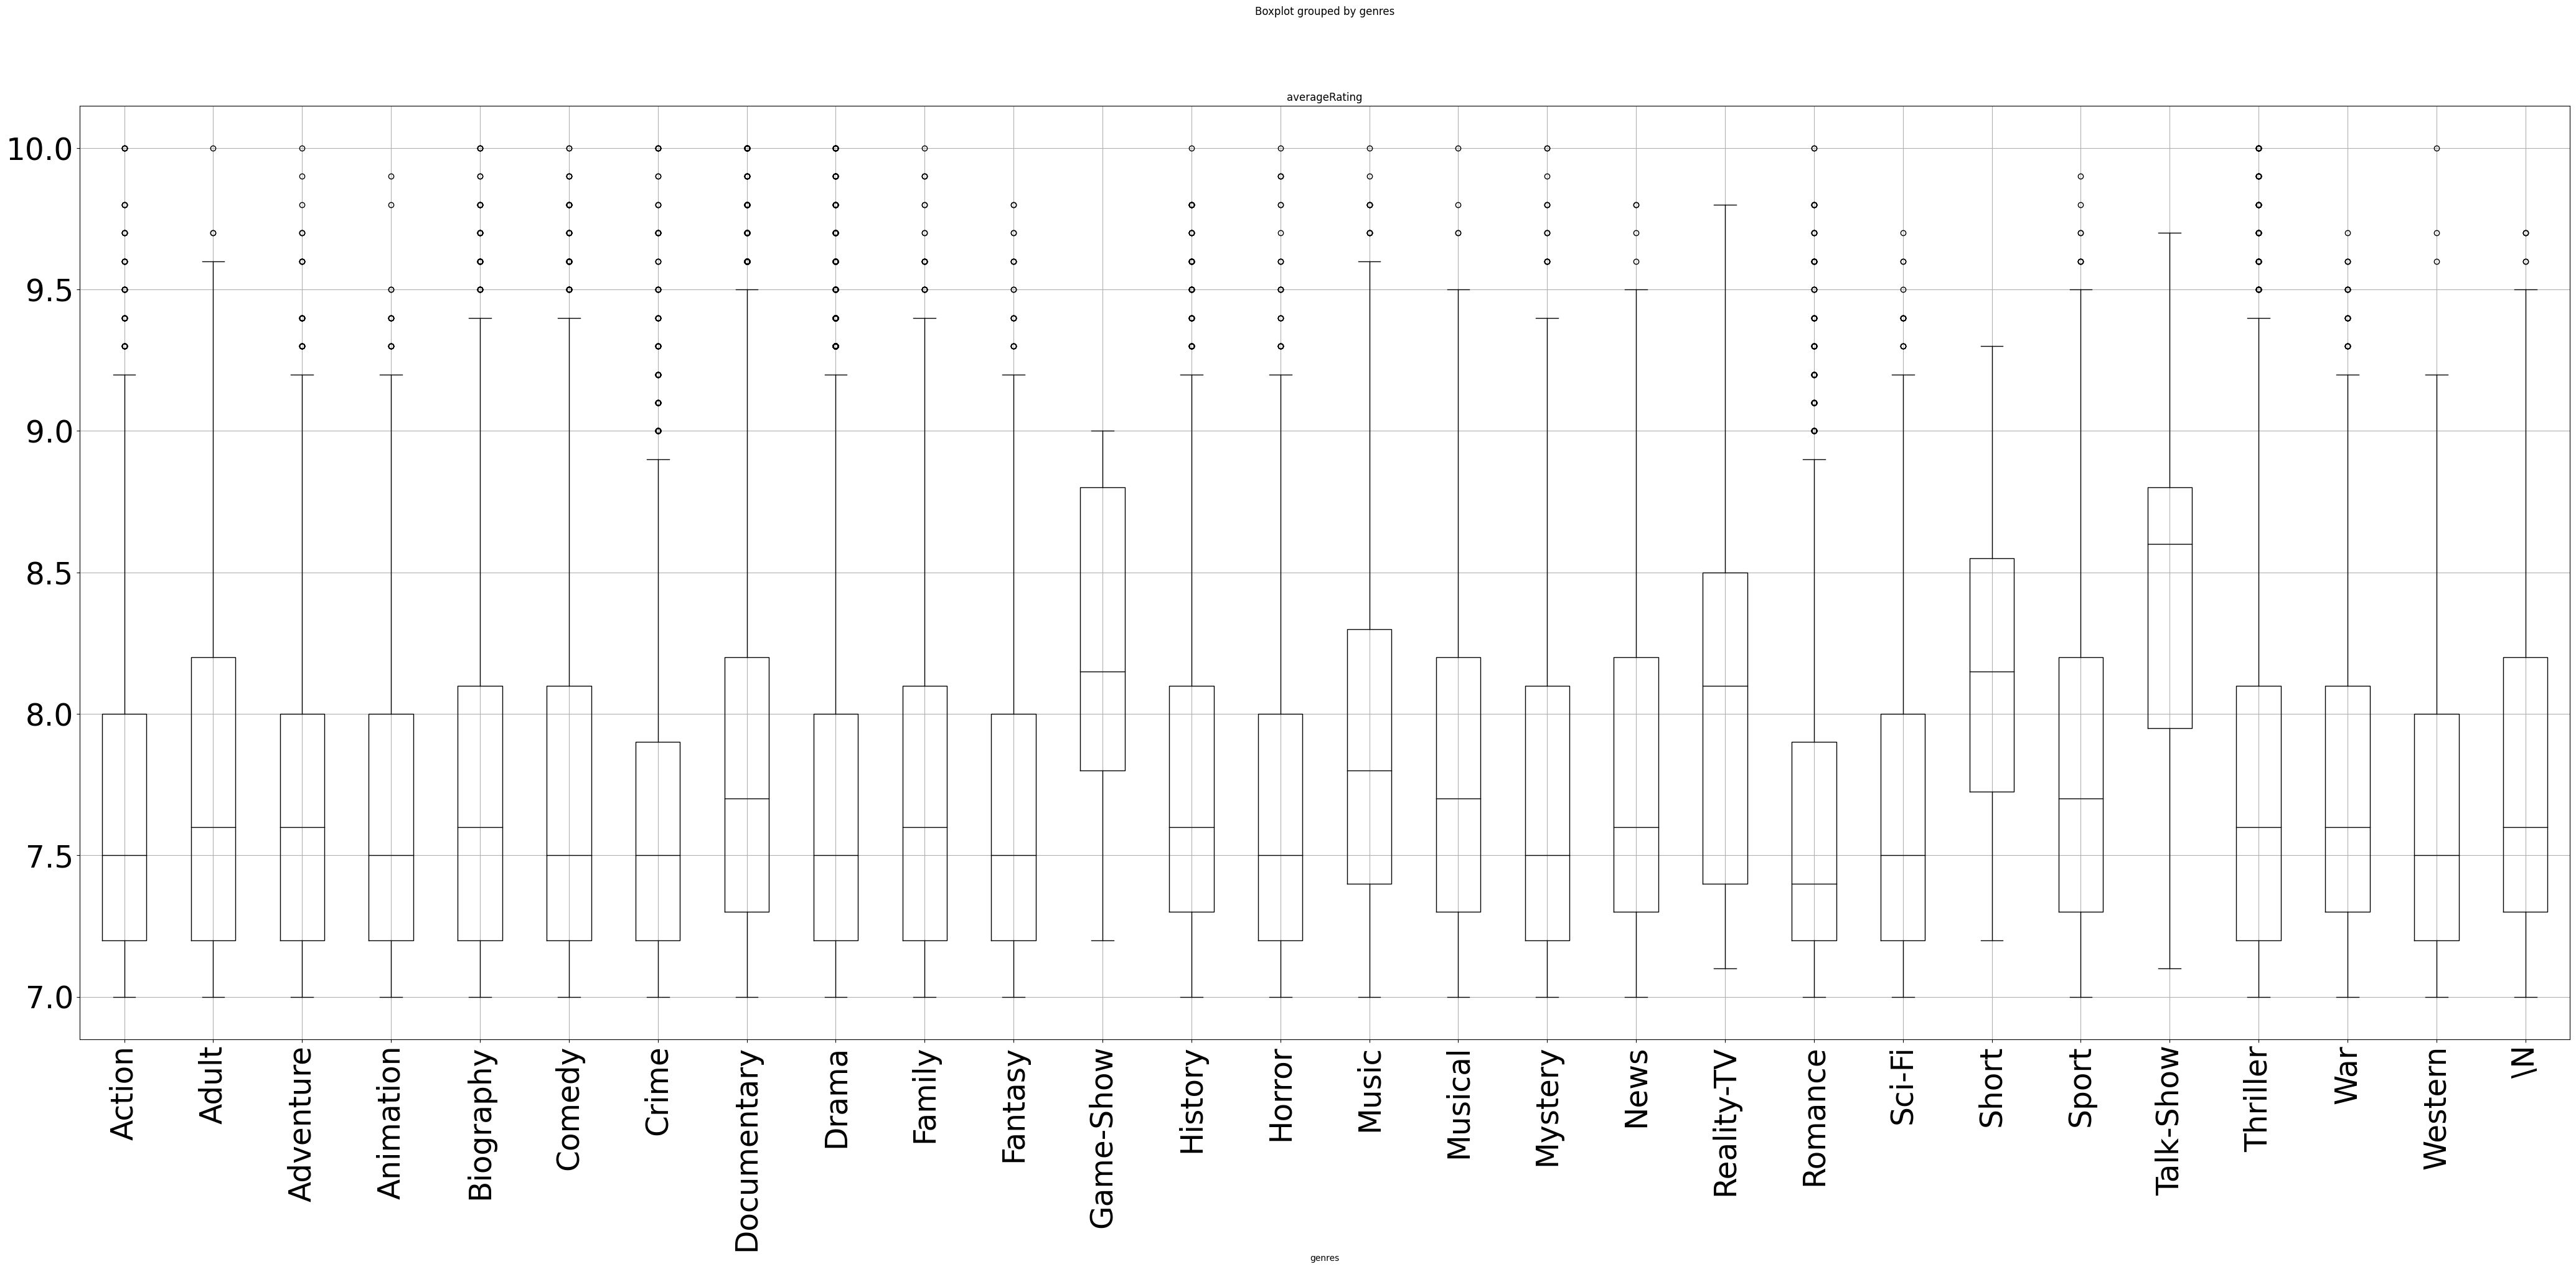

In [ ]:
df_genre.boxplot(column='averageRating', by='genres', figsize=(50,20), color='black', fontsize='35', rot='vertical')

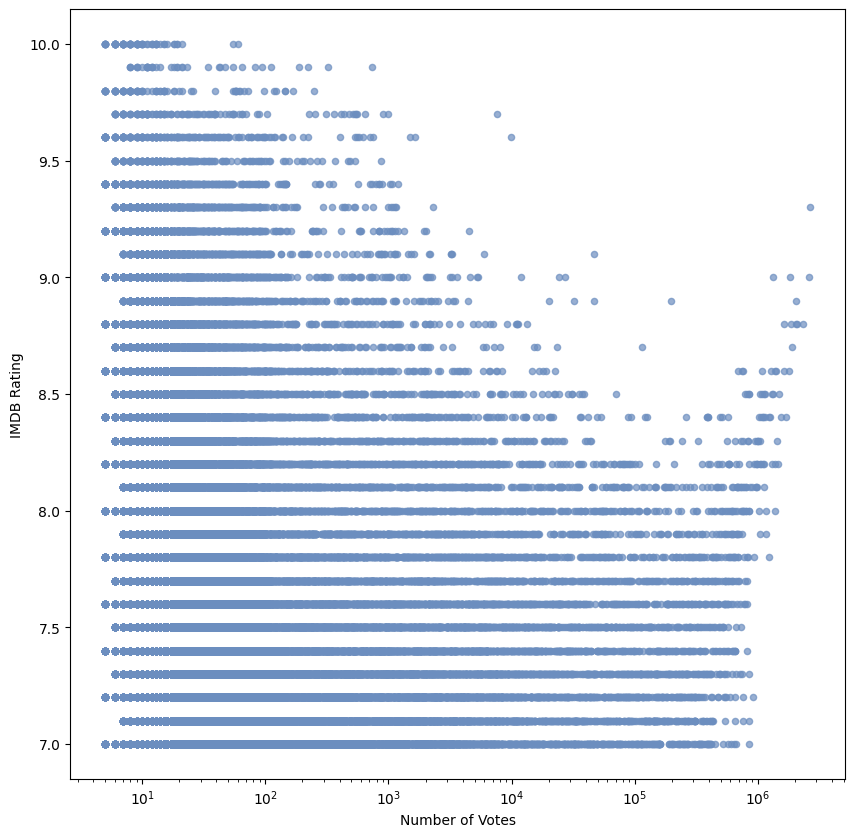

In [ ]:

df.plot(kind='scatter', x='numVotes', y='averageRating', logx=True, alpha=0.7, color=['#6C8EBF'], figsize=(10,10))
plt.ylabel('IMDB Rating')
plt.xlabel('Number of Votes')
plt.show()

In [ ]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')
                    

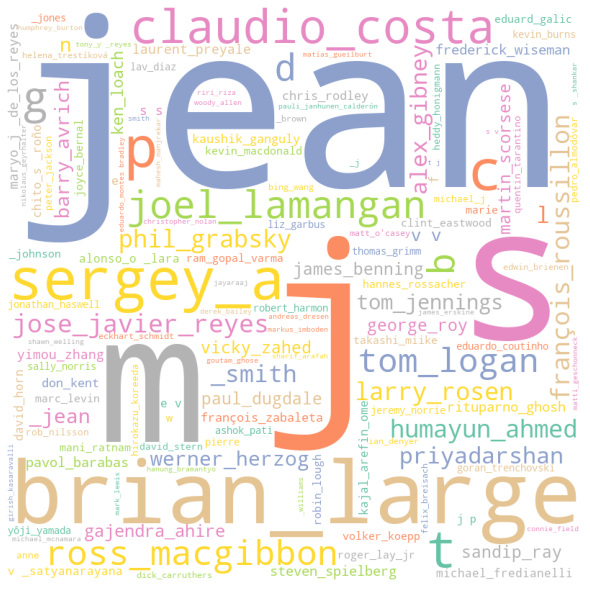

In [ ]:
df_directors['directors'] = df_directors['directors'].apply(lambda x: '_'.join(str(x).split(' ')))
df_directors = df_directors[df_directors['directors'] != 'nan']

comment_words = ''

for index, row in df_directors.iterrows():
    val = str(row['directors'])
    tokens = val.split()
     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(comment_words)
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [8]:
def return_text(df):
    comment_words = ''

    for index, row in df.iterrows():
        val = str(row['synopsis'])

        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "  
    return comment_words


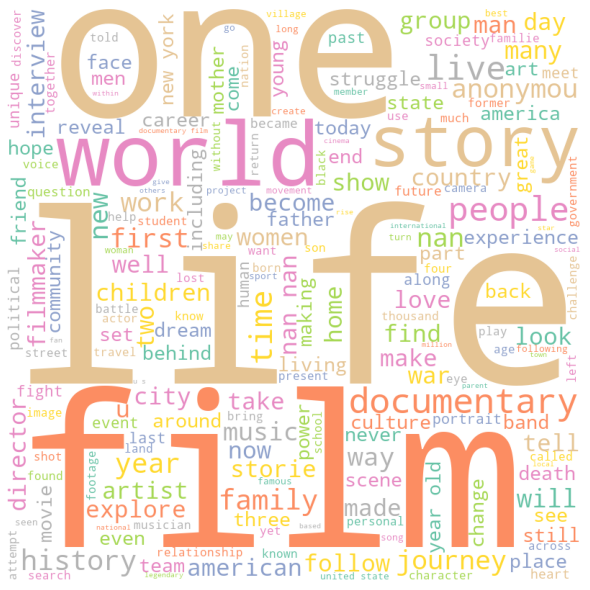

In [ ]:
documentary = df_genre[df_genre['genres'] == 'Documentary']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(documentary))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

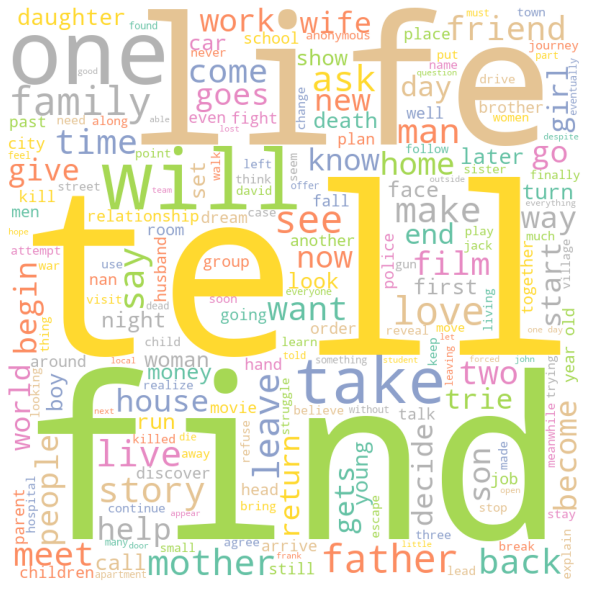

In [ ]:
drama = df_genre[df_genre['genres'] == 'Drama']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(drama))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

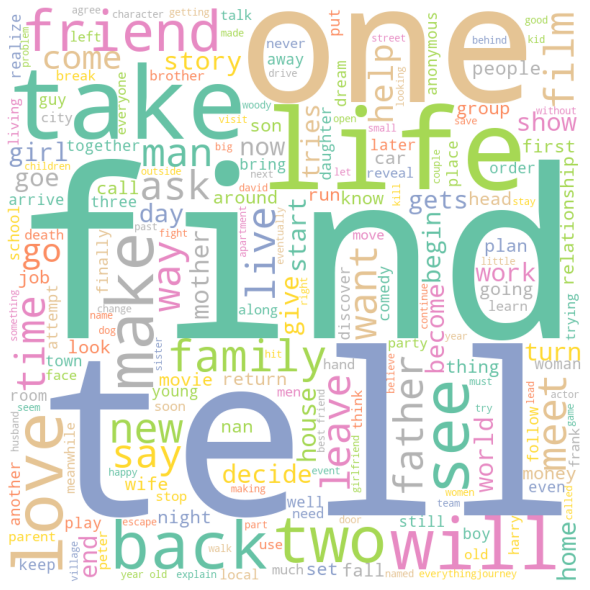

In [ ]:
comedy = df_genre[df_genre['genres'] == 'Comedy']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(comedy))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()



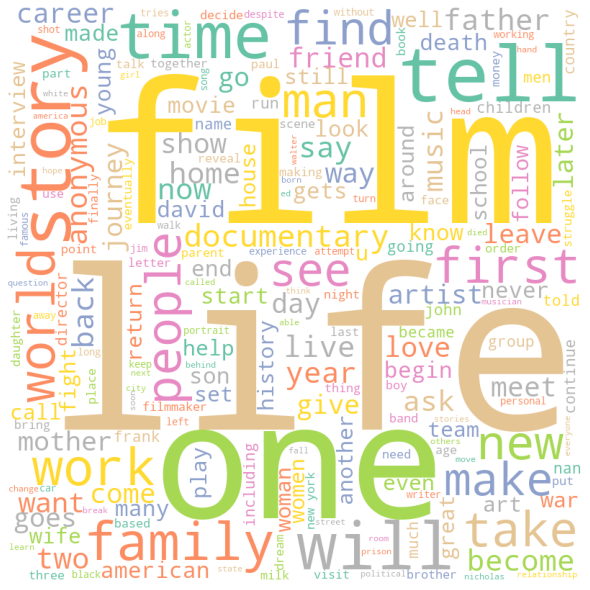

In [10]:
biography = df_genre[df_genre['genres'] == 'Biography']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(biography))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

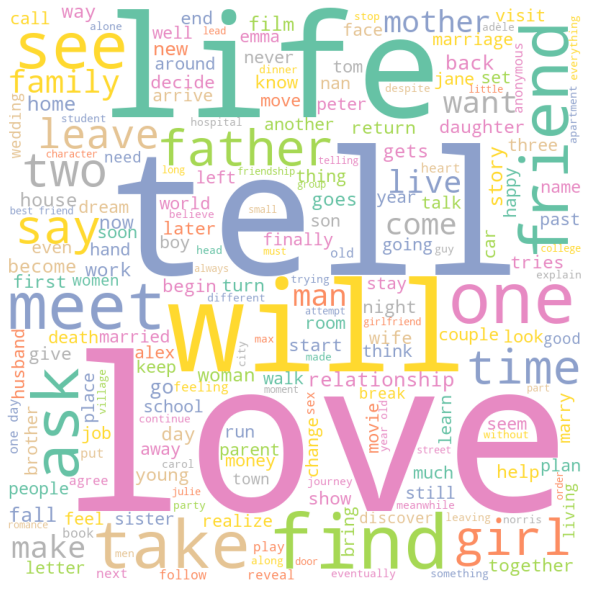

In [ ]:
romance = df_genre[df_genre['genres'] == 'Romance']

wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white', 
    colormap='Set2',
    min_font_size=10).generate(return_text(romance))
 
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [ ]:
import spacy
from spacy.cli import download

download("en_core_web_sm")


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0-py3-none-any.whl (12.8 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip3 install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
NER = spacy.load("en_core_web_sm")

text1= NER(return_text(biography)[:1000000])

for word in text1.ents:
    print(word.text,word.label_)

manoel de oliveira's PERSON
portugal GPE
german NORP
oppingen PERSON
germany GPE
1933 through 1945 DATE
the 1930s DATE
3 1/2 years DATE
100 CARDINAL
nazi party ORG
german NORP
german NORP
jewish NORP
brandeis university ORG
alias caruga PERSON
michael PERSON
british NORP
seven-year DATE
the last seven years DATE
19th century DATE
french NORP
arthur PERSON
chinese NORP
hong kong GPE
one CARDINAL
hong kong GPE
december 8, 1970. DATE
jim morrison PERSON
val kilmer PERSON
john densmore PERSON
american NORP
27th ORDINAL
the 1950s DATE
new mexico GPE
two CARDINAL
one CARDINAL
american NORP
indian NORP
jim watches PERSON
1965 DATE
california GPE
los angeles GPE
oliver stone PERSON
kyle maclachlan PERSON
venice GPE
pamela courson PERSON
meg ORG
two CARDINAL
two CARDINAL
john densmore PERSON
kevin dillon PERSON
robby krieger PERSON
frank whaley PERSON
first ORDINAL
robby PERSON
one CARDINAL
first ORDINAL
this.one year later DATE
1966 DATE
michael wincott PERSON
six days DATE
sam whipple PERSON


In [11]:
from keybert import KeyBERT

kw_model = KeyBERT(model='all-mpnet-base-v2')

keywords = kw_model.extract_keywords(return_text(biography), 

                                     keyphrase_ngram_range=(1, 3), 

                                     stop_words='english', 

                                     highlight=False,

                                     top_n=10)

keywords_list= list(dict(keywords).keys())

print(keywords_list)